In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Required Modules


In [2]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2025-09-24 10:23:45.231494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758709425.587266      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758709425.674907      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading the images

In [3]:
# 📁 Step 1: Load and preprocess images
def load_images_from_folder(folder_path, target_size=(224, 224)):
    images = []
    labels = []
    class_names = os.listdir(folder_path)
    
    for label in class_names:
        class_folder = os.path.join(folder_path, label)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            images.append(img_array)
            labels.append(label)
    
    return np.array(images), np.array(labels)

## Loading the dataset

In [4]:
# 📦 Load dataset
dataset_path = '/kaggle/input/cassava-disease-dataset/Cassava'  # Replace with your actual path
X_images, y_labels = load_images_from_folder(dataset_path)
print("Done loading the dataset")

Done loading the dataset


## Feature Extraction using ResNet 50

In [5]:
# 🧠 Step 2: Feature extraction using ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
features = resnet_model.predict(X_images, verbose=1)

I0000 00:00:1758709481.362061      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758709481.362745      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1758709498.030340      98 service.cc:148] XLA service 0x7c257414b020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758709498.031380      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758709498.031402      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758709498.663101      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/235 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step

I0000 00:00:1758709502.930430      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step


## Data Split

In [6]:
#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, y_labels, test_size=0.2, random_state=42)

## Training the random forest model

In [7]:
# 🌲 Step 4: Train Random Forest classifier
hybrid_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
hybrid_rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

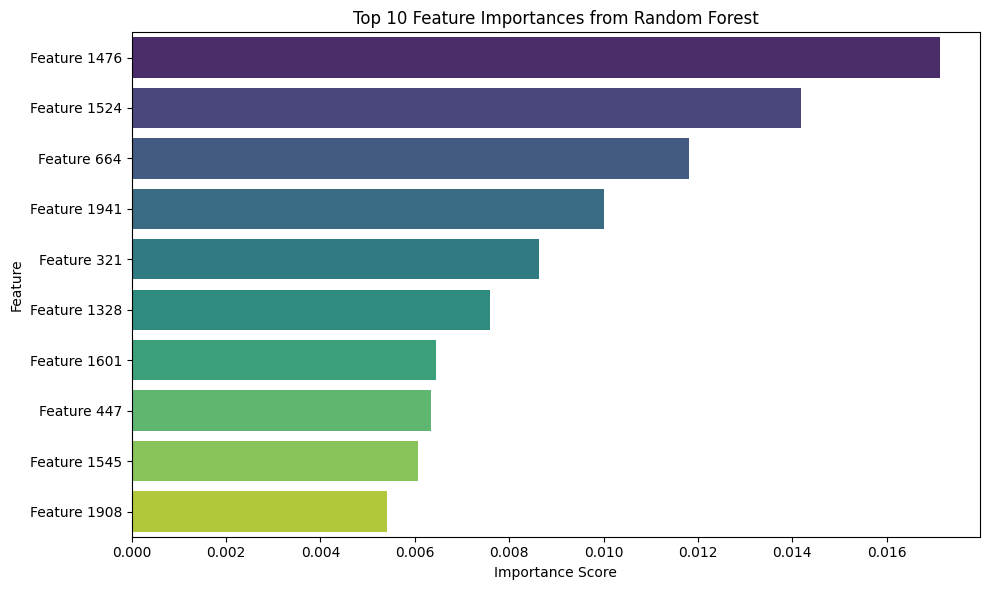

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances from the trained model
importances = hybrid_rf_model.feature_importances_

# If your features are unnamed (e.g., from CNN), label them numerically
feature_names = [f'Feature {i}' for i in range(len(importances))]

# Create a DataFrame for visualization
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
plt.title('Top 10 Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Performance Evaluation

In [9]:
# 📊 Step 5: Evaluate
hybrid_y_pred = hybrid_rf_model.predict(X_test)
print(classification_report(y_test, hybrid_y_pred))


                  precision    recall  f1-score   support

bacterial blight       0.85      0.92      0.88       533
      brown spot       0.90      0.81      0.85       291
      green mite       0.88      0.86      0.87       206
         healthy       0.93      0.92      0.92       226
          mosaic       0.94      0.91      0.93       246

        accuracy                           0.89      1502
       macro avg       0.90      0.88      0.89      1502
    weighted avg       0.89      0.89      0.89      1502



## Building a Random Forest Model without the feature extraction

In [10]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#  Flatten image data: (num_samples, height, width, channels) → (num_samples, features)
X_flat = X_images.reshape(X_images.shape[0], -1)

#  Train-test split
rf_X_train, rf_X_test, rf_y_train, _  = train_test_split(X_flat, y_labels, test_size=0.2, random_state=42)

In [11]:
#  Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(rf_X_train, rf_y_train)

RandomForestClassifier(random_state=42)

# Evaluating the model's performance

In [12]:
#  Evaluate
y_pred = rf_model.predict(rf_X_test)
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

bacterial blight       0.52      0.85      0.65       533
      brown spot       0.57      0.42      0.49       291
      green mite       0.57      0.17      0.27       206
         healthy       0.82      0.76      0.79       226
          mosaic       0.65      0.38      0.48       246

        accuracy                           0.59      1502
       macro avg       0.63      0.52      0.53      1502
    weighted avg       0.60      0.59      0.56      1502



## Model Performance Comparison

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, precision_recall_curve
)

# Evaluate metrics
def get_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred , average='macro'),
        'Recall': recall_score(y_true, y_pred, average='macro'),
        'F1 Score': f1_score(y_true, y_pred, average='macro')
    }

metrics_rf = get_metrics(y_test, y_pred)
metrics_hybrid = get_metrics(y_test, hybrid_y_pred)


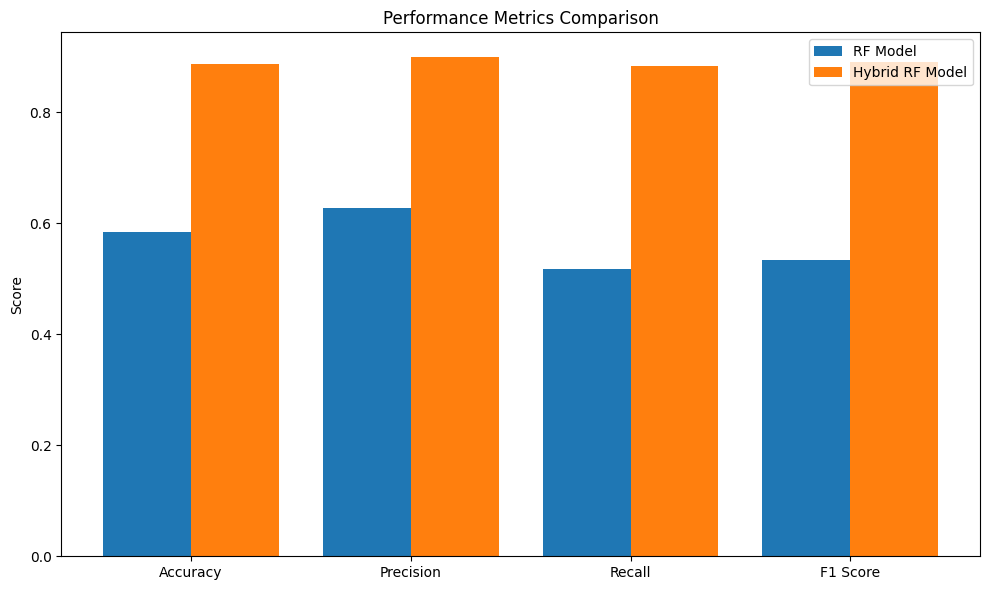

In [14]:
# 📊 Bar Plot of Metrics
plt.figure(figsize=(10, 6))
labels = list(metrics_rf.keys())
rf_values = list(metrics_rf.values())
hybrid_values = list(metrics_hybrid.values())

x = range(len(labels))
plt.bar(x, rf_values, width=0.4, label='RF Model', align='center')
plt.bar([i + 0.4 for i in x], hybrid_values, width=0.4, label='Hybrid RF Model', align='center')
plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.legend()
plt.tight_layout()
plt.show()


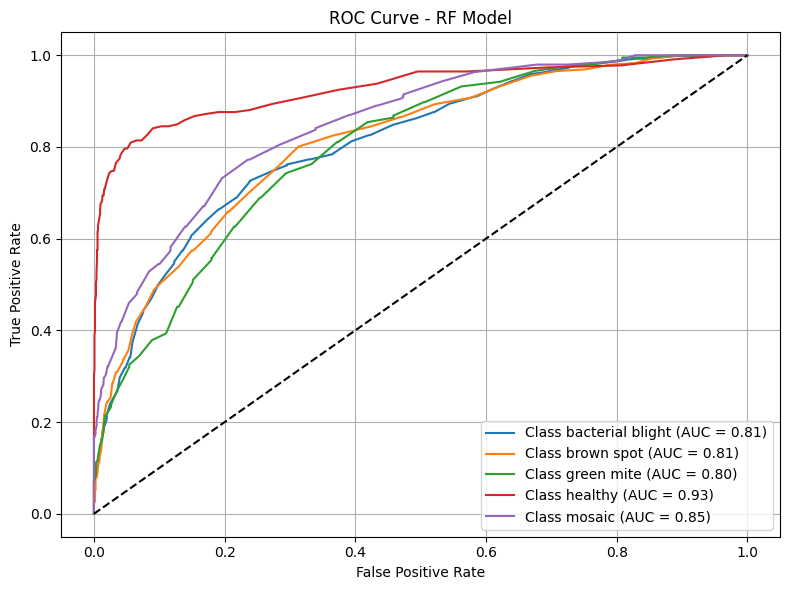

In [15]:
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# ------------------------
# 📊 RF Model ROC Curve
# ------------------------
y_pred_proba = rf_model.predict_proba(rf_X_test)

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RF Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



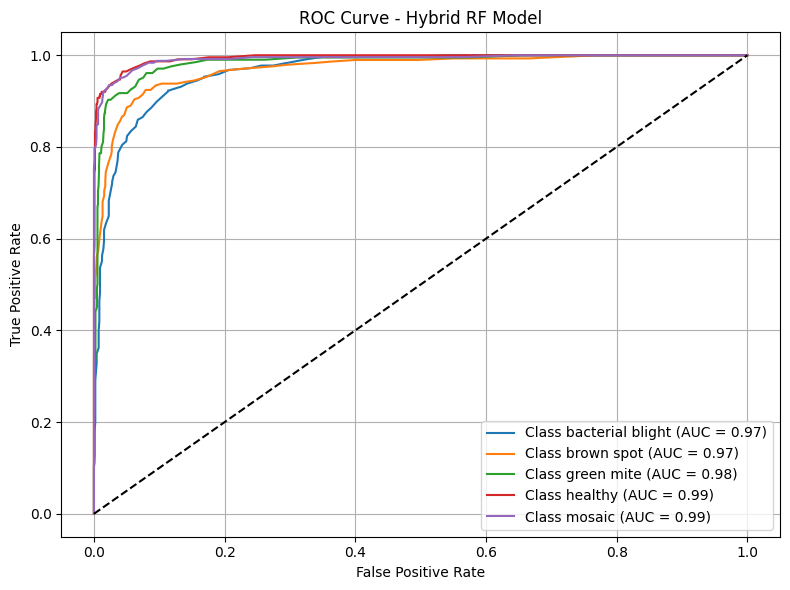

In [16]:
hybrid_y_pred_proba = hybrid_rf_model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], hybrid_y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Hybrid RF Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


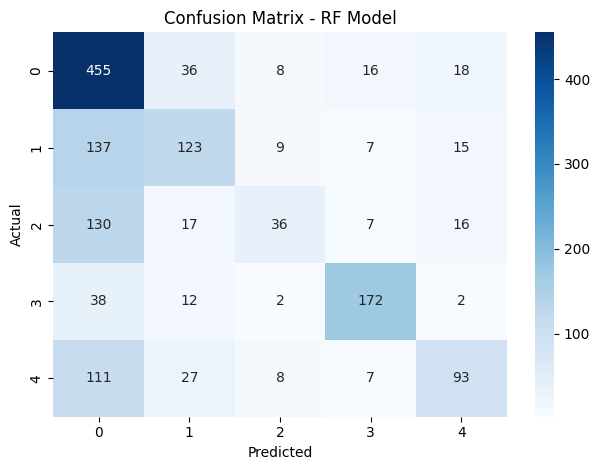

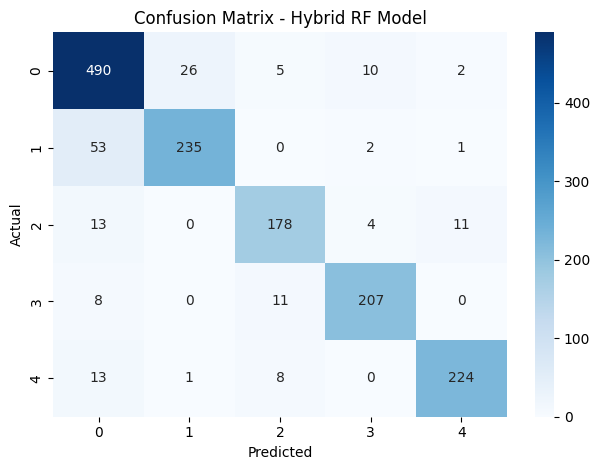

In [17]:
# Confusion Matrices
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

plot_conf_matrix(y_test, y_pred, 'Confusion Matrix - RF Model')
plot_conf_matrix(y_test, hybrid_y_pred, 'Confusion Matrix - Hybrid RF Model')


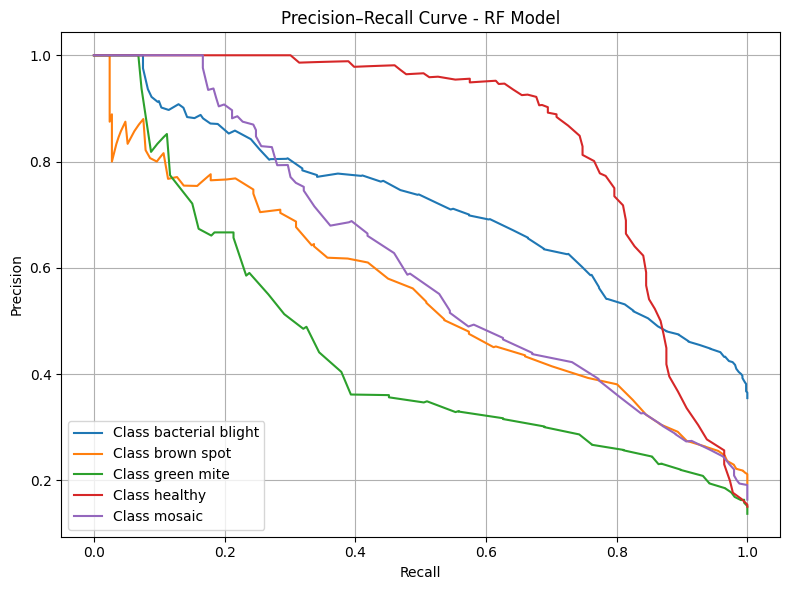

In [18]:
from sklearn.preprocessing import label_binarize

# Binarize true labels for multiclass
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

y_pred_proba = rf_model.predict_proba(rf_X_test)

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {class_label}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve - RF Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

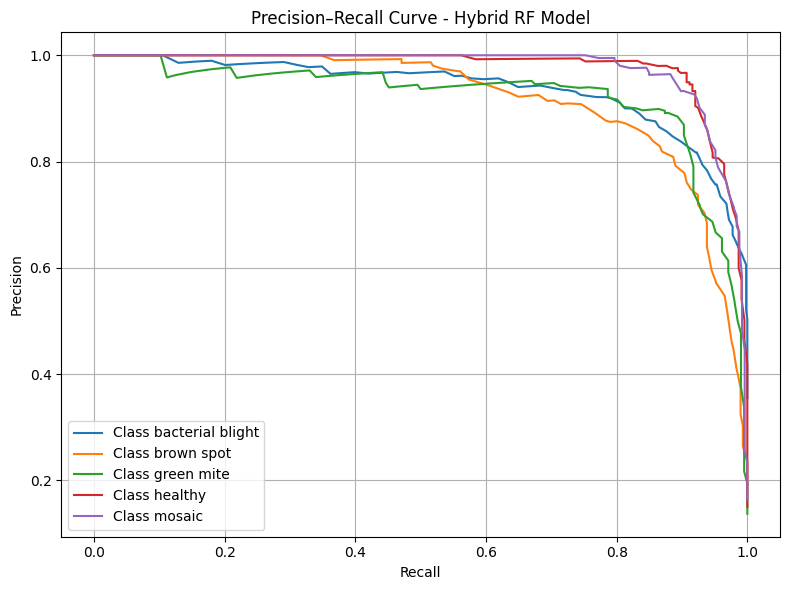

In [19]:

# ------------------------
# Hybrid RF Model PR Curve
# ------------------------
hybrid_y_pred_proba = hybrid_rf_model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], hybrid_y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {class_label}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve - Hybrid RF Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Saving Model for Development

In [20]:
import joblib 


joblib.dump(hybrid_rf_model, "hybrid_model.pkl")

['hybrid_model.pkl']